# RATIO 2019 - Benchmarking Workshop

https://gluon-nlp.mxnet.io/install.html

```
pip install --upgrade 'mxnet>=1.3.0'
pip install gluonnlp
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
unzip sentence_embedding.zip
ln -s sentence_embedding/bert bert
```

In [1]:
import datetime
import logging
import os
import random
import time
import warnings

import csv
import gluonnlp as nlp
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import seaborn as sns

from bert import *
from mxnet import gluon
from mxnet.gluon.data import Dataset, SimpleDataset
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import utils
from tqdm import tqdm

In [ ]:
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [3]:
# set repeatable random state
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

In [4]:
# apply progress bars for pandas .apply() -> .progress_apply()
tqdm.pandas()

In [5]:
class Timer:
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.time_start = time.time()

    def __exit__(self, *exc):
        time_end = time.time()
        time_delta = datetime.timedelta(seconds=(time_end - self.time_start))
        if self.name:
            print(("Time for [{}]: {}".format(self.name, time_delta)))
        else:
            print(("Time: {}".format(time_delta)))

# Task 1 - Same Side Classification

In [6]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'

### Load within-topics and cross-topics data

In [7]:
# escapechar to detect quoting escapes, else it fails

# na_filter=False, because pandas automatic "nan" detection fails with the topic column, too
# cross_test_df['topic'].astype(str)[9270]

# within has "is_same_side" as string (boolean after latest update)
# cross has "is_same_side" as boolean (auto cast?)

with Timer("read cross"):
    # cross_traindev_df = pd.read_csv(data_cross_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # cross_test_df = pd.read_csv(data_cross_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    cross_traindev_df = pd.read_csv(data_cross_path.format('training'),
                                    quotechar='"',
                                    quoting=csv.QUOTE_ALL,
                                    encoding='utf-8',
                                    escapechar='\\',
                                    doublequote=False,
                                    index_col='id')
    cross_test_df = pd.read_csv(data_cross_path.format('test'),
                                quotechar='"',
                                quoting=csv.QUOTE_ALL,
                                encoding='utf-8',
                                escapechar='\\',
                                doublequote=False,
                                index_col='id')

with Timer("read within"):
    # within_traindev_df = pd.read_csv(data_within_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # within_test_df = pd.read_csv(data_within_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    within_traindev_df = pd.read_csv(data_within_path.format('training'),
                                     quotechar='"',
                                     quoting=csv.QUOTE_ALL,
                                     encoding='utf-8',
                                     escapechar='\\',
                                     doublequote=False,
                                     index_col='id')
    within_test_df = pd.read_csv(data_within_path.format('test'),
                                 quotechar='"',
                                 quoting=csv.QUOTE_ALL,
                                 encoding='utf-8',
                                 escapechar='\\',
                                 doublequote=False,
                                 index_col='id')

Time for [read cross]: 0:00:01.230329
Time for [read within]: 0:00:01.147553


In [8]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if "abortion" in title:
        row['tag'] = 'abortion'
    elif "gay marriage"  in title:
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row


with Timer("tag cross traindev"):
    cross_traindev_df = cross_traindev_df.progress_apply(add_tag, axis=1)
with Timer("tag cross test"):
    cross_test_df = cross_test_df.progress_apply(add_tag, axis=1)

with Timer("tag within traindev"):
    within_traindev_df = within_traindev_df.progress_apply(add_tag, axis=1)
with Timer("tag within test"):
    within_test_df = within_test_df.progress_apply(add_tag, axis=1)

  1%|          | 204/34330 [00:00<00:16, 2033.78it/s]

Time for [tag cross traindev]: 0:00:37.228385


  0%|          | 135/63903 [00:00<00:47, 1341.32it/s]

Time for [tag cross test]: 0:00:20.382879


  0%|          | 112/31475 [00:00<00:28, 1116.12it/s]

Time for [tag within traindev]: 0:00:39.191730


100%|██████████| 31475/31475 [00:19<00:00, 1644.94it/s]

Time for [tag within test]: 0:00:19.151194


### Get an overview about each dataset

In [9]:
# requires nltk  wordtokenize
# from nltk.tokenize import sent_tokenize, word_tokenize
# model uses BERT Tokenizer ...

def get_overview(df, task='same-side', class_name='is_same_side'):
    # Total instance numbers
    total = len(df)
    print("Task: ", task)
    print('=' * 40, '\n')

    print('Total instances: ', total)
    print('\n')

    print('For each topic:')
    for tag, tag_df in df.groupby(['tag']):
        print(tag, ': ', len(tag_df), ' instances')
        if class_name in df.columns:
            for is_same_side, side_df in tag_df.groupby([class_name]):
                print('\t\t', is_same_side, ': ', len(side_df), ' instances')
    print('\n')

    if class_name in df.columns:
        print('For each class value:')
        for class_value, class_df in df.groupby([class_name]):
            print(class_value, ': ', len(class_df), ' instances')
        print('\n')

    print('Unique argument1:', len(df['argument1'].unique()))
    print('Unique argument2:', len(df['argument2'].unique()))
    arguments = df['argument1'].values
    arguments = np.concatenate([arguments, df['argument2'].values])

    print('Unique total arguments:', len(set(list(arguments))), '\n')
    
    return

    print('-' * 40, '\n')

    arguments_length_lst = [
        len(word_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_length_lst.extend(
        [len(word_tokenize(x)) for x in df['argument2'].values])
    print('Words:')
    print('\tshortest argument:', min(arguments_length_lst), ' words')
    print('\tlongest argument:', max(arguments_length_lst), ' words')
    print('\targument average length:', np.mean(arguments_length_lst),
          ' words')

    arguments_sent_length_lst = [
        len(sent_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_sent_length_lst.extend(
        [len(sent_tokenize(x)) for x in df['argument2'].values])
    print('Sentences:')
    print('\tshortest argument:', min(arguments_sent_length_lst), ' sentences')
    print('\tlongest argument:', max(arguments_sent_length_lst), ' sentences')
    print('\targument average length:', np.mean(arguments_sent_length_lst),
          ' sentences')

In [ ]:
with Timer("overview cross"):
    get_overview(cross_traindev_df)

In [ ]:
with Timer("overview within"):
    get_overview(within_traindev_df)

##### Count raw length

In [ ]:
def compute_arg_len(row):
    row['argument1_len'] = len(row['argument1'])
    row['argument2_len'] = len(row['argument2'])
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    return row


cross_traindev_df = cross_traindev_df.progress_apply(compute_arg_len, axis=1)
within_traindev_df = within_traindev_df.progress_apply(compute_arg_len, axis=1)
cross_test_df = cross_test_df.progress_apply(compute_arg_len, axis=1)
within_test_df = within_test_df.progress_apply(compute_arg_len, axis=1)

In [ ]:
cross_traindev_df.describe()

In [ ]:
within_traindev_df.describe()

##### Tokenize and count tokens

In [ ]:
ctx = mx.cpu()
_, vocabulary = nlp.model.get_model('bert_12_768_12',
                                    dataset_name='book_corpus_wiki_en_uncased',
                                    pretrained=True, ctx=ctx, use_pooler=True,
                                    use_decoder=False, use_classifier=False)
bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
tokenizer = bert_tokenizer

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('punct')


# tokenizer from BERT
def tokenize_arguments(row):
    # tokenize
    row['argument1_tokens'] = tokenizer(row['argument1'])
    row['argument2_tokens'] = tokenizer(row['argument2'])

    # count tokens
    row['argument1_len'] = len(row['argument1_tokens'])
    row['argument2_len'] = len(row['argument2_tokens'])
    # token number diff
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    return row


cross_traindev_df = cross_traindev_df.progress_apply(tokenize_arguments, axis=1)
within_traindev_df = within_traindev_df.progress_apply(tokenize_arguments, axis=1)
cross_test_df = cross_test_df.progress_apply(tokenize_arguments, axis=1)
within_test_df = within_test_df.progress_apply(tokenize_arguments, axis=1)

In [ ]:
cross_traindev_df.describe()

In [ ]:
within_traindev_df.describe()

In [ ]:
def plot_lengths(df, slicen=None, abs_diff=True, title=None):
    if df is None:
        print("no lengths to plot")
        return
    
    arg1_lens = df['argument1_len']
    arg2_lens = df['argument2_len']
    arg_diff_len = df['argument12_len_diff']
    
    if abs_diff:
        arg_diff_len = np.abs(arg_diff_len)
    
    if slicen is not None:
        arg1_lens = arg1_lens[slicen]
        arg2_lens = arg2_lens[slicen]
        arg_diff_len = arg_diff_len[slicen]

    x = np.arange(len(arg1_lens))  # arange/linspace

    plt.subplot(2, 1, 1)
    plt.plot(x, arg1_lens, label='argument1')  # Linie: '-', 'o-', '.-'
    plt.plot(x, arg2_lens, label='argument2')  # Linie: '-', 'o-', '.-'
    plt.legend()
    plt.title('Lengths of arguments' if not title else title)
    plt.ylabel('Lengths of arguments 1 and 2')

    plt.subplot(2, 1, 2)
    plt.plot(x, arg_diff_len)
    plt.xlabel('Index')
    plt.ylabel('Differences')

    plt.show()


plot_lengths(within_traindev_df, slice(None, None, 500), title='Length of arguments within train/dev, every 500')
plot_lengths(cross_traindev_df, slice(None, None, 500), title='Length of arguments cross train/dev, every 500')
plot_lengths(within_test_df, slice(None, None, 1), title='Length of arguments within test')

## Train model - Baseline

### train dev set - 70% 30%

In [10]:
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic']]
    y = df[['is_same_side']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

### BERT

- https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html

In [11]:
class MyBERTDataset(SimpleDataset):
    def __init__(self, X, y=None):
        self._X = X
        self._y = y
        super(MyBERTDataset, self).__init__(self._convert())

    def _convert(self):
        allsamples = list()

        if self._y is not None:
            df = self._X.merge(self._y, left_index=True, right_index=True)
            for _, row in df.iterrows():
                allsamples.append([
                    row['argument1'], row['argument2'],
                    "1" if str(row['is_same_side']) == "True" else "0"
                ])
                #allsamples.append([row['argument1'], row['argument2'], 1 if str(row['is_same_side']) == "True" else 0])

        else:
            for _, row in self._X.iterrows():
                allsamples.append([row['argument1'], row['argument2'], None])

        return allsamples

**TODO**: my own `BERTDatasetTransform` for extracting chunks from arguments or last part etc.

```python
transform = dataset.BERTDatasetTransform(bert_tokenizer, 512,
                                         labels=['0', '1'],
                                         label_dtype='int32',
                                         pad=True,
                                         pair=True)
```

http://localhost:9001/edit/bert/dataset.py @454
```python
# substitute with my own (e. g. last part, many parts etc.)
def __init__(...):
    self._bert_xform = BERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)
```
https://gluon-nlp.mxnet.io/master/_modules/gluonnlp/data/transforms.html#BERTSentenceTransform
```python
# substitute with my own (e. g. only last part (trim from start))
self._truncate_seq_pair(tokens_a, tokens_b, self._max_seq_length - 3)
```

https://mxnet.incubator.apache.org/_modules/mxnet/gluon/data/dataset.html#Dataset.transform

In [12]:
from gluonnlp.data import BERTSentenceTransform


class FirstAndLastPartBERTSentenceTransform(BERTSentenceTransform):
    def __init__(self, tokenizer, max_seq_length, pad=True, pair=True):
        super(FirstAndLastPartBERTSentenceTransform,
              self).__init__(tokenizer, max_seq_length, pad=pad, pair=pair)

    def __call__(self, line):
        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer(text_a)
        tokens_a_epi = tokens_a.copy()
        tokens_b = None
        tokens_b_epi = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)
            tokens_b_epi = tokens_b.copy()

        if tokens_b:
            self._truncate_seq_pair_prolog(tokens_a, tokens_b,
                                           self._max_seq_length - 3)
            self._truncate_seq_pair_epilog(tokens_a_epi, tokens_b_epi,
                                           self._max_seq_length - 3)
        else:
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]
            if len(tokens_a_epi) > self._max_seq_length - 2:
                tokens_a_epi = tokens_a_epi[0:(self._max_seq_length - 2)]

        vocab = self._tokenizer.vocab
        tokens, tokens_epi = [], []
        tokens.append(vocab.cls_token)
        tokens_epi.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens_epi.extend(tokens_a_epi)
        tokens.append(vocab.sep_token)
        tokens_epi.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)
        segment_ids_epi = [0] * len(tokens_epi)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens_epi.extend(tokens_b_epi)
            tokens.append(vocab.sep_token)
            tokens_epi.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))
            segment_ids_epi.extend([1] * (len(tokens) - len(segment_ids_epi)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)
        input_ids_epi = self._tokenizer.convert_tokens_to_ids(tokens_epi)
        valid_length = len(input_ids)
        valid_length_epi = len(input_ids_epi)

        if self._pad:
            padding_length = self._max_seq_length - valid_length
            padding_length_epi = self._max_seq_length - valid_length_epi
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            input_ids_epi.extend([vocab[vocab.padding_token]] *
                                 padding_length_epi)
            segment_ids.extend([0] * padding_length)
            segment_ids_epi.extend([0] * padding_length_epi)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32'), np.array(input_ids_epi, dtype='int32'),\
            np.array(valid_length_epi, dtype='int32'), np.array(segment_ids_epi, dtype='int32')

    def _truncate_seq_pair_prolog(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop()
            else:
                tokens_b.pop()

    def _truncate_seq_pair_epilog(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length.
        Removes from end of token list."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop(0)
            else:
                tokens_b.pop(0)

In [13]:
class FirstAndLastPartBERTDatasetTransform(dataset.BERTDatasetTransform):
    def __init__(self,
                 tokenizer,
                 max_seq_length,
                 labels=None,
                 pad=True,
                 pair=True,
                 label_dtype='float32'):
        super(FirstAndLastPartBERTDatasetTransform,
              self).__init__(tokenizer,
                             max_seq_length,
                             labels=labels,
                             pad=pad,
                             pair=pair,
                             label_dtype=label_dtype)
        self._bert_xform = FirstAndLastPartBERTSentenceTransform(
            tokenizer, max_seq_length, pad=pad, pair=pair)

    def __call__(self, line):
        input_ids, valid_length, segment_ids, input_ids_epi, valid_length_epi, segment_ids_epi = self._bert_xform(
            line[:-1])

        label = line[-1]
        if self.labels:  # for classification task
            label = self._label_map[label]
        label = np.array([label], dtype=self.label_dtype)

        return input_ids, valid_length, segment_ids, input_ids_epi, valid_length_epi, segment_ids_epi, label

In [14]:
from mxnet.gluon import Block
from mxnet.gluon import nn


class BERTProEpiClassifier(Block):
    """Model for sentence (pair) classification task with BERT.

    The model feeds token ids and token type ids into BERT to get the
    pooled BERT sequence representation, then apply a Dense layer for
    classification. Does this also for an adversarial classifier.

    Parameters
    ----------
    bert: BERTModel
        Bidirectional encoder with transformer.
    num_classes : int, default is 2
        The number of target classes.
    dropout : float or None, default 0.0.
        Dropout probability for the bert output.
    prefix : str or None
        See document of `mx.gluon.Block`.
    params : ParameterDict or None
        See document of `mx.gluon.Block`.
    """

    def __init__(self,
                 bert,
                 num_classes=2,
                 dropout=0.0,
                 prefix=None,
                 params=None):
        super(BERTProEpiClassifier, self).__init__(prefix=prefix, params=params)
        self.bert = bert
        with self.name_scope():
            self.classifier = nn.HybridSequential(prefix=prefix)
            if dropout:
                self.classifier.add(nn.Dropout(rate=dropout))
            self.classifier.add(nn.Dense(units=num_classes))

    def forward(self,
                inputs,
                token_types,
                valid_length=None,
                inputs_epi=None,
                token_types_epi=None,
                valid_length_epi=None):  # pylint: disable=arguments-differ
        """Generate the unnormalized scores for the given the input sequences.
        From both classifiers (classifier + adversarial_classifier).

        Parameters
        ----------
        inputs : NDArray, shape (batch_size, seq_length)
            Input words for the sequences.
        token_types : NDArray, shape (batch_size, seq_length)
            Token types for the sequences, used to indicate whether the word belongs to the
            first sentence or the second one.
        valid_length : NDArray or None, shape (batch_size)
            Valid length of the sequence. This is used to mask the padded tokens.
        inputs_epi : NDArray or None, shape (batch_size, seq_length)
            Input words for the sequences. If None then same as inputs.
        token_types_epi : NDArray or None, shape (batch_size, seq_length)
            Token types for the sequences, used to indicate whether the word belongs to the
            first sentence or the second one. If None then same as token_types.
        valid_length_epi : NDArray or None, shape (batch_size)
            Valid length of the sequence. This is used to mask the padded tokens.

        Returns
        -------
        outputs : NDArray
            Shape (batch_size, num_classes), outputs of classifier.
        """
        # if inputs_epi is None and token_types_epi is None:
        #     inputs_epi = inputs
        #     token_types_epi = token_types
        #     valid_length_epi = valid_length

        _, pooler_out = self.bert(inputs, token_types, valid_length)
        _, pooler_out_epi = self.bert(inputs_epi, token_types_epi, valid_length_epi)
        pooler_concat = mx.nd.concat(pooler_out, pooler_out_epi, dim=1)
        return self.classifier(pooler_concat)

In [15]:
def setup_bert():
    # change `ctx` to `mx.cpu()` if no GPU is available.
    ctx = mx.gpu(0)
    # ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
    # ctx = mx.cpu()

    bert_base, vocabulary = nlp.model.get_model(
        'bert_12_768_12',
        dataset_name='book_corpus_wiki_en_uncased',
        pretrained=True,
        ctx=ctx,
        use_pooler=True,
        use_decoder=False,
        use_classifier=False)
    print(bert_base)

    model = BERTProEpiClassifier(bert_base, num_classes=2, dropout=0.1)
    #model = BERTProEpiClassifier(bert_base, num_classes=1, dropout=0.1)
    # only need to initialize the classifier layer.
    model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.hybridize(static_alloc=True)

    # softmax cross entropy loss for classification
    loss_function = gluon.loss.SoftmaxCELoss()
    #loss_function = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
    loss_function.hybridize(static_alloc=True)

    metric = mx.metric.Accuracy()

    # use the vocabulary from pre-trained model for tokenization
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
    # maximum sequence length
    # max_len = 128  # + batch_size: 32
    # 384 - 12
    max_len = 512  # + batch_size: 6 ?
    # the labels for the two classes
    all_labels = ["0", "1"]
    #all_labels = [0, 1]
    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    transform = FirstAndLastPartBERTDatasetTransform(bert_tokenizer,
                                                     max_len,
                                                     labels=all_labels,
                                                     label_dtype='int32',
                                                     pad=True,
                                                     pair=True)

    return model, vocabulary, ctx, bert_tokenizer, transform, loss_function, metric, all_labels

In [16]:
def transform_dataset(X, y, transform):
    data_train_raw = MyBERTDataset(X, y)
    data_train = data_train_raw.transform(transform)
    return data_train_raw, data_train


def predict_out_to_ys(all_predictions, all_labels):
    y_true, y_pred = list(), list()

    for _, y_true_many, y_pred_many in all_predictions:
        y_true_many = y_true_many.T[0].asnumpy()
        # https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss
        # pred: the prediction tensor, where the batch_axis dimension ranges over batch size and axis dimension ranges over the number of classes.
        y_pred_many = np.argmax(y_pred_many, axis=1).asnumpy()

        y_true.extend(list(y_true_many))
        y_pred.extend(list(y_pred_many))
        # TODO: convert label_id to label?
        # y_pred.extend(all_labels[c] for c in list(y_pred_many))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return y_true, y_pred

In [17]:
def train(model,
          data_train,
          ctx,
          metric,
          loss_function,
          batch_size=32,
          lr=5e-6,
          num_epochs=3,
          checkpoint_dir="data",
          use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [
            p for p in model.collect_params().values() if p.grad_req != 'null'
        ]

    log_interval = 10
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(
                    epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(
                        checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               token_ids_epi, valid_length_epi,
                               segment_ids_epi,
                               label) in enumerate(bert_dataloader):
                    with mx.autograd.record():

                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        token_ids_epi = token_ids_epi.as_in_context(ctx)
                        valid_length_epi = valid_length_epi.as_in_context(ctx)
                        segment_ids_epi = segment_ids_epi.as_in_context(ctx)
                        label = label.as_in_context(ctx)

                        # forward computation
                        out = model(token_ids, segment_ids,
                                    valid_length.astype('float32'),
                                    token_ids_epi, segment_ids_epi,
                                    valid_length_epi.astype('float32'))
                        #label = label.astype('float32')
                        ls = loss_function(out, label).mean()

                    # backward computation
                    ls.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    step_loss += ls.asscalar()
                    #out = out.sigmoid().round().astype('int32')
                    #label = label.astype('int32')
                    metric.update([label], [out])
                    stats.append((metric.get()[1], ls.asscalar()))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(
                                epoch_id, batch_id + 1, len(bert_dataloader),
                                step_loss / log_interval,
                                trainer.learning_rate,
                                metric.get()[1],
                                datetime.timedelta(seconds=(time.time() -
                                                            t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)

    return stats

In [18]:
def predict(model, data_predict, ctx, metric, loss_function, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict,
                                               batch_size=batch_size)

    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        for batch_id, (token_ids, valid_length, segment_ids, token_ids_epi,
                       valid_length_epi, segment_ids_epi,
                       label) in enumerate(tqdm(bert_dataloader)):
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            token_ids_epi = token_ids_epi.as_in_context(ctx)
            valid_length_epi = valid_length_epi.as_in_context(ctx)
            segment_ids_epi = segment_ids_epi.as_in_context(ctx)
            label = label.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids, valid_length.astype('float32'),
                        token_ids_epi, segment_ids_epi,
                        valid_length_epi.astype('float32'))
            #label = label.astype('float32')
            ls = loss_function(out, label).mean()

            #out = out.sigmoid().round().astype('int32')
            #label = label.astype('int32')
            metric.update([label], [out])
            cum_loss += ls.asscalar()  # .sum() ?
            all_predictions.append((batch_id, label, out))

    return all_predictions, cum_loss

In [19]:
def print_infos(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s' % vocabulary)
    print('[PAD] token id = %s' % (vocabulary['[PAD]']))
    print('[CLS] token id = %s' % (vocabulary['[CLS]']))
    print('[SEP] token id = %s' % (vocabulary['[SEP]']))

    print('token ids = \n%s' % data_train[sample_id][0])
    print('valid length = \n%s' % data_train[sample_id][1])
    print('segment ids = \n%s' % data_train[sample_id][2])
    print('epi token ids = \n%s' % data_train[sample_id][3])
    print('epi valid length = \n%s' % data_train[sample_id][4])
    print('epi segment ids = \n%s' % data_train[sample_id][5])
    print('label = \n%s' % data_train[sample_id][6])


def plot_train_stats(stats):
    if not stats:
        print("no stats to plot")
        return

    x = np.arange(len(stats))  # arange/linspace

    acc_dots, loss_dots = zip(*stats)

    plt.subplot(2, 1, 1)
    plt.plot(x, acc_dots)  # Linie: '-', 'o-', '.-'
    plt.title('Training BERTClassifier')
    plt.ylabel('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_dots)
    plt.xlabel('Batches')
    plt.ylabel('Loss')

    plt.show()

### Evaluate

In [20]:
def heatconmat(y_test, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(np.unique(y_test)))
    plt.show()


def report_training_results(y_test, y_pred, name=None, heatmap=True):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    if heatmap:
        heatconmat(y_test, y_pred)
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2), '\n')  #

    print('Report{}:'.format("" if not name else " for [{}]".format(name)))
    print(classification_report(y_test, y_pred))

    f1_dic = {}
    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), 2)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 2)
    return f1_dic

### Within topic - Training and evaluating model 

In [21]:
within_traindev_df = within_traindev_df[:1000]

In [22]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df)

Time for [1 - test/train split]: 0:00:00.009893


In [23]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [24]:
print(model)

BERTProEpiClassifier(
  (bert): BERTModel(
    (encoder): BERTEncoder(
      (dropout_layer): Dropout(p = 0.1, axes=())
      (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
      (transformer_cells): HybridSequential(
        (0): BERTEncoderCell(
          (dropout_layer): Dropout(p = 0.1, axes=())
          (attention_cell): MultiHeadAttentionCell(
            (_base_cell): DotProductAttentionCell(
              (_dropout_layer): Dropout(p = 0.1, axes=())
            )
            (proj_query): Dense(768 -> 768, linear)
            (proj_key): Dense(768 -> 768, linear)
            (proj_value): Dense(768 -> 768, linear)
          )
          (proj): Dense(768 -> 768, linear)
          (ffn): BERTPositionwiseFFN(
            (ffn_1): Dense(768 -> 3072, linear)
            (activation): GELU()
            (ffn_2): Dense(3072 -> 768, linear)
            (dropout_layer): Dropout(p = 0.1, axes=())
            (layer_norm): BERTLayerNorm(eps=1e-12

In [25]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

pro: pro-choice con: pro-life i would consider my views regarding abortion more on the pro life side, and here is why. for one, abortion is murder, murder is wrong. secondly, no woman has the right to terminate another life, this is not an issue of body autonomy or woman"s rights, it"s about whether women have the right to end another life because it"s more convenient for her to do so. lastly, i do not believe that abortions should be illegal all together, there should be exceptions, just like every other law that operates in today"s society. the only cases where abortion should be an option for women is when: 1-it is the product of rape/incest. 2- it is apparent that having the child poses a deadly threat to the mother, i. e, it is predictable that the mother will be seriously harmed/killed in the process of giving birth to the baby. women should not have the right to end the life of another because it is more convienient for her to end its life.
i hope to change your mind on this top

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/within-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [26]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

marriage is not about love, but starting family margarette somerville. "the case against gay marriage." mcgill center for medicine, ethics and law. april 29, 2003: "jonathan rauch, in his recent book gay marriage: why it is good for gays, good for straights, and good for america, defines marriage as essentially a legally enforced, long-term relation of mutual aid and support between two sexual partners. marriage, he says, "is putting one person ahead of all others." according to rauch, "if marriage means anything at all," it is knowing "that there is someone out there for whom you are always first in line." we can here leave aside how odd this definition will sound to any married couple with young children, partners whose first responsibility is not obviously spousal."
denying marriage to infertile would be too costly adam kolasinksi. "the secular case against gay marriage." the tech (m.i.t.) february 20th, 2004: "a small minority of married couples are infertile. however, excluding st

In [ ]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/within-topic/bert.model.params", ctx=ctx)
    model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

### Train and evaluate each epoch

100%|██████████| 700/700 [00:02<00:00, 238.34it/s]


Time for [setup training]: 0:00:02.945971
[Epoch 0 Batch 10/353] loss=0.7496, lr=0.0000050, acc=0.500 - time 0:00:07.286613
[Epoch 0 Batch 20/353] loss=0.7705, lr=0.0000050, acc=0.487 - time 0:00:05.740098
[Epoch 0 Batch 30/353] loss=0.7293, lr=0.0000050, acc=0.525 - time 0:00:06.516846
[Epoch 0 Batch 40/353] loss=0.7326, lr=0.0000050, acc=0.506 - time 0:00:06.150889
[Epoch 0 Batch 50/353] loss=0.6718, lr=0.0000050, acc=0.505 - time 0:00:06.745883
[Epoch 0 Batch 60/353] loss=0.8377, lr=0.0000050, acc=0.471 - time 0:00:06.122975
[Epoch 0 Batch 70/353] loss=0.8019, lr=0.0000050, acc=0.460 - time 0:00:06.686329
[Epoch 0 Batch 80/353] loss=0.6848, lr=0.0000050, acc=0.484 - time 0:00:06.073261
[Epoch 0 Batch 90/353] loss=0.6448, lr=0.0000050, acc=0.492 - time 0:00:06.653632
[Epoch 0 Batch 100/353] loss=0.7408, lr=0.0000050, acc=0.480 - time 0:00:05.907560
[Epoch 0 Batch 110/353] loss=0.7660, lr=0.0000050, acc=0.463 - time 0:00:06.727626
[Epoch 0 Batch 120/353] loss=0.6827, lr=0.0000050, acc

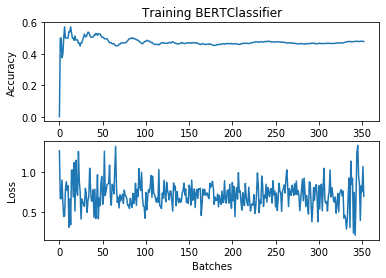

  0%|          | 0/50 [00:00<?, ?it/s]

Time for [4 - train model - 0]: 0:03:49.378720


100%|██████████| 50/50 [00:20<00:00,  2.52it/s]


Time for [prediction]: 0:00:20.243516
Accuracy in epoch 0: 0.5666666666666667
Confusion Matrix:
[[  0 124]
 [  6 170]]

Accuracy:  0.57 

Report for [BERTClassifier - last part]:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       124
           1       0.58      0.97      0.72       176

    accuracy                           0.57       300
   macro avg       0.29      0.48      0.36       300
weighted avg       0.34      0.57      0.42       300

Time for [6 - evaluate - 0]: 0:00:20.271037


In [27]:
for epoch_id in range(1):
    with Timer("4 - train model - {}".format(epoch_id)):
        # stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=2, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        # all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=6)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier - last part", heatmap=False)

    model.save_parameters("data/bert.model.params")

*may need to use **binary_cross_entrophy**?* (can I use a single label or do I have to use "0" and "1"?)

### Cross topic - Training and evaluating model 

In [ ]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(cross_traindev_df)

In [ ]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/cross-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [ ]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/cross-topic/bert.model.params", ctx=ctx)
    model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")